# Data Retrieval

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
import pandas as pd
import IPython.display
import matplotlib.pyplot as plt
import csv
import re
import numpy as np
from datetime import datetime
import statsmodels.api as sm

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
plt.style.use('seaborn')

In [4]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

sf_file = file_url.format('sf_airbnb/listings_details')
ok_file = file_url.format('ok_airbnb/listings_details')
sc_file = file_url.format('sc_airbnb/listings_details')

In [5]:
# Loaded files as DataFrame

date_to_parse = ['last_scraped','host_since', 'first_review', 'last_review']

listings_sf = pd.read_csv(sf_file, parse_dates=date_to_parse)
listings_ok = pd.read_csv(ok_file, parse_dates=date_to_parse)
listings_sc = pd.read_csv(sc_file, parse_dates=date_to_parse)

print('sf file dimensions: ', listings_sf.shape) 
print('ok file dimensions: ', listings_ok.shape) 
print('sc file dimensions: ', listings_sc.shape) 

sf file dimensions:  (6633, 96)
ok file dimensions:  (2898, 96)
sc file dimensions:  (5668, 96)


In [6]:
# Concatenated four files into one
# Created keys for each file for future references

frames = [listings_sf, listings_ok, listings_sc]
keys = ['sf', 'ok', 'sc']

df_listings = pd.concat(frames, keys=keys)
df_listings.reset_index()

df_listings.head()

id                        listing_url     scrape_id last_scraped  \
sf 0   958   https://www.airbnb.com/rooms/958  2.018080e+13   2018-08-06   
   1  5858  https://www.airbnb.com/rooms/5858  2.018080e+13   2018-08-06   
   2  7918  https://www.airbnb.com/rooms/7918  2.018080e+13   2018-08-06   
   3  8142  https://www.airbnb.com/rooms/8142  2.018080e+13   2018-08-06   
   4  8339  https://www.airbnb.com/rooms/8339  2.018080e+13   2018-08-06   

                                                   name  \
sf 0                Bright, Modern Garden Unit - 1BR/1B   
   1                                 Creative Sanctuary   
   2         A Friendly Room - UCSF/USF - San Francisco   
   3  Friendly Room Apt. Style -UCSF/USF - San Franc...   
   4                    Historic Alamo Square Victorian   

                                                summary  \
sf 0  Our bright garden unit overlooks a grassy back...   
   1                                                NaN   
   2  Nice and good public transportation.  7 minute...   
   3  Nice and good public transportation.  7 minute...   
   4  Pls email before booking.  Interior featured i...   

                                                  space  \
sf 0  Newly remodeled, modern, and bright garden uni...   
   1  We live in a large Victorian house on a quiet ...   
   2  Room rental-sunny view room/sink/Wi Fi (inner ...   
   3  Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...   
   4  Please send us a quick message before booking ...   

                                            description experiences_offered  \
sf 0  Our bright garden unit overlooks a grassy back...                none   
   1  We live in a large Victorian house on a quiet ...                none   
   2  Nice and good public transportation.  7 minute...                none   
   3  Nice and good public transportation.  7 minute...                none   
   4  Pls email before booking.  Interior featured i...                none   

                                  neighborhood_overview        ...          \
sf 0  *Quiet cul de sac in friendly neighborhood *St...        ...           
   1  I love how our neighborhood feels quiet but is...        ...           
   2  Shopping old town, restaurants, McDonald, Whol...        ...           
   3                                                NaN        ...           
   4                                                NaN        ...           

     requires_license      license jurisdiction_names instant_bookable  \
sf 0                t  STR-0001256  {"SAN FRANCISCO"}                f   
   1                t          NaN  {"SAN FRANCISCO"}                f   
   2                t          NaN  {"SAN FRANCISCO"}                f   
   3                t          NaN  {"SAN FRANCISCO"}                f   
   4                t  STR-0000264  {"SAN FRANCISCO"}                f   

     is_business_travel_ready          cancellation_policy  \
sf 0                        f                     moderate   
   1                        f  strict_14_with_grace_period   
   2                        f  strict_14_with_grace_period   
   3                        f  strict_14_with_grace_period   
   4                        f  strict_14_with_grace_period   

      require_guest_profile_picture require_guest_phone_verification  \
sf 0                              f                                f   
   1                              f                                f   
   2                              f                                f   
   3                              f                                f   
   4                              t                                t   

      calculated_host_listings_count  reviews_per_month  
sf 0                               1               1.38  
   1                               1               0.99  
   2                               9               0.16  
   3                               9               0.15  
 

In [7]:
# Added additional column to keep track of original district

df_listings['district'] = ''

df_listings.loc['sf']['district'] = 'San Francisco'
df_listings.loc['ok']['district'] = 'Oakland'
df_listings.loc['sc']['district'] = 'Santa Clara'
# df_listings.loc['scz']['district'] = 'Santa Cruz'

In [8]:
# Created a separate dataframe to keep track of district
# The data frame will be used in later stage

df_district =  df_listings.loc[:, ['id', 'district']]
df_district.head()

id       district
sf 0   958  San Francisco
   1  5858  San Francisco
   2  7918  San Francisco
   3  8142  San Francisco
   4  8339  San Francisco

# Data Exploration

## Smaller Set of Features

In [9]:
# Checked for Null vales within data

display(df_listings.isnull().sum())

id                                      0
listing_url                             0
scrape_id                               0
last_scraped                            0
name                                    2
summary                               442
space                                3216
description                           124
experiences_offered                     0
neighborhood_overview                4934
notes                                6690
transit                              4937
access                               4817
interaction                          5375
house_rules                          4416
thumbnail_url                       15199
medium_url                          15199
picture_url                             0
xl_picture_url                      15199
host_id                                 0
host_url                                0
host_name                               0
host_since                              0
host_location                     

In [10]:
# Columns removed/dropped:
# Removed columns with >90% null values: 'experience_offered', 'host_acceptance_rate', \ 
#'neighbourhood_group_cleansed', 'square_feet'
# Removed 'jurisdiction_names', 'neighbourhood', kept'neighbourhood_cleansed'
# Noted'city' and 'smart location' provide duplicate information, removed 'smart location'
# Removed 'Country code' and 'country', as all instances locate within US


columns_to_keep =[
       'id','host_since','host_response_time', 'host_response_rate',
        'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 
       'host_has_profile_pic', 'host_identity_verified', 
        'neighbourhood_cleansed',
       'city', 
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type','amenities', 
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included',  'minimum_nights','number_of_reviews',
       'first_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'jurisdiction_names', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'district']


df_listings_smaller = df_listings[columns_to_keep]
display ('Dimensions after drilling down: ' ,df_listings_smaller.shape)
df_listings_smaller.head()

'Dimensions after drilling down: '

(15199, 43)

id host_since  host_response_time host_response_rate  \
sf 0   958 2008-07-31      within an hour                92%   
   1  5858 2009-03-02      within an hour               100%   
   2  7918 2009-06-17  within a few hours               100%   
   3  8142 2009-06-17  within a few hours               100%   
   4  8339 2009-07-02      within an hour               100%   

     host_is_superhost  host_listings_count  host_total_listings_count  \
sf 0                 t                    1                          1   
   1                 f                    2                          2   
   2                 f                   10                         10   
   3                 f                   10                         10   
   4                 f                    2                          2   

     host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
sf 0                    t                      t       Western Addition   
   1                    t                      t         Bernal Heights   
   2                    t                      t         Haight Ashbury   
   3                    t                      t         Haight Ashbury   
   4                    t                      t       Western Addition   

          ...       review_scores_value jurisdiction_names instant_bookable  \
sf 0      ...                      10.0  {"SAN FRANCISCO"}                f   
   1      ...                       9.0  {"SAN FRANCISCO"}                f   
   2      ...                       8.0  {"SAN FRANCISCO"}                f   
   3      ...                       9.0  {"SAN FRANCISCO"}                f   
   4      ...                      10.0  {"SAN FRANCISCO"}                f   

     is_business_travel_ready          cancellation_policy  \
sf 0                        f                     moderate   
   1                        f  strict_14_with_grace_period   
   2                        f  strict_14_with_grace_period   
   3                        f  strict_14_with_grace_period   
   4                        f  strict_14_with_grace_period   

      require_guest_profile_picture  require_guest_phone_verification  \
sf 0                              f                                 f   
   1                              f                                 f   
   2                              f                                 f   
   3                              f                                 f   
   4                              t                                 t   

      calculated_host_listings_count reviews_per_month       district  
sf 0                               1              1.38  San Francisco  
   1                               1              0.99  San Francisco  
   2                               9              0.16  San Francisco  
   3                               9              0.15  San Francisco  
   4                               2              0.24  San Francisco  

[5 rows x 43 columns]

## Data Format

In [11]:
def apply2df(df, column_names, function):
    """
    This enables various functions to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to, function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

### Percentage

In [12]:
# Noted percentage features are formated as strings, and need to be converted
# to float format

def percent2float(string):
    """
    Convert strings with percentage sign to float
    """
    percentage = float(str(string).strip('%'))/100.0
    return percentage

In [13]:
print ('Type: ', type(df_listings_smaller.host_response_rate[0]))
df_listings_smaller.host_response_rate[0:5]

Type:  <class 'str'>


sf  0     92%
    1    100%
    2    100%
    3    100%
    4    100%
Name: host_response_rate, dtype: object

In [14]:
# Converted percentage features to float format

percents = ['host_response_rate']

df_listings_smaller = apply2df(df_listings_smaller, percents, percent2float)

In [15]:
df_listings_smaller.host_response_rate[0:5]

sf  0    0.92
    1    1.00
    2    1.00
    3    1.00
    4    1.00
Name: host_response_rate, dtype: float64

### Currency

In [16]:
# Noted currency features are formated as strings, and need to be converted 
# to float format

def currency2float(string):
    """
    Convert currency to float
    """
    string = str(string).strip(' ').replace(' \\n', '')
    float_ = float(string.strip('$').replace(',',''))
    return float_

In [17]:
print ('Type of price: ', type(df_listings_smaller.price[0]))
display (df_listings_smaller.price[0:5])

print ('Type of security deposit: ', type(df_listings_smaller.security_deposit[0]))
display(df_listings_smaller.security_deposit[0:5])

print ('Type of security deposit: ', type(df_listings_smaller.cleaning_fee[0]))
display(df_listings_smaller.cleaning_fee[0:5])

Type of price:  <class 'str'>


sf  0    $170.00 
    1    $235.00 
    2     $65.00 
    3     $65.00 
    4    $675.00 
Name: price, dtype: object

Type of security deposit:  <class 'str'>


sf  0    $100.00 
    1         NaN
    2    $200.00 
    3    $200.00 
    4      $0.00 
Name: security_deposit, dtype: object

Type of security deposit:  <class 'str'>


sf  0    $100.00 
    1    $100.00 
    2     $50.00 
    3     $50.00 
    4    $225.00 
Name: cleaning_fee, dtype: object

In [18]:
# Converted currency features to float

curriencies = ['price', 'security_deposit', 'cleaning_fee']

df_listings_smaller = apply2df(df_listings_smaller, curriencies, currency2float)

### Timestamp

In [19]:
# This is to convert timestamp features to duration
# Duration is calculated by: 
# number of years between original timestamp and current year

def duration(starting_time):
    """
    Calculate duration or number of years between current year and starting_time
    """
    starting_year = starting_time.year
    current_year = datetime.now().year
    duration = current_year - starting_year + 1
    
    return duration

In [20]:
# Converted timestamp features to duration

timestamps = ['host_since', 'first_review']

df_listings_smaller = apply2df(df_listings_smaller, timestamps, duration)

In [21]:
# Rename columns to reflect duration nature

mapper = {'host_since' : 'host_yrs', 'first_review': 'yrs_since_1st_review'}

df_listings_smaller.rename(columns=mapper, inplace=True)

In [22]:
df_listings_smaller.columns

Index(['id', 'host_yrs', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'city', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'number_of_reviews',
       'yrs_since_1st_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'jurisdiction_names',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'district'],
      dtype='obje

## Outliers

In [23]:
df_listings_smaller.price.describe(percentiles=[.05, .10, .25, .50, .75, .90, .95])

count    15199.000000
mean       182.285019
std        279.583024
min          0.000000
5%          40.000000
10%         50.000000
25%         75.000000
50%        124.000000
75%        200.000000
90%        325.000000
95%        480.000000
max      10000.000000
Name: price, dtype: float64

In [24]:
# Outliers removal. Kept only values between 5% and 95% percentiles

five_percentitle = np.percentile(df_listings_smaller['price'], 5)
ninety_five_percentitle = np.percentile(df_listings_smaller['price'], 95)

df_listings_smaller = df_listings_smaller[
                     (df_listings_smaller['price']<=ninety_five_percentitle) 
                      & (df_listings_smaller['price']>=five_percentitle)]

display(df_listings_smaller.shape)

(13789, 43)

In [25]:
df_listings_smaller.price.describe()

count    13789.000000
mean       146.076945
std         89.295031
min         40.000000
25%         79.000000
50%        121.000000
75%        190.000000
max        480.000000
Name: price, dtype: float64

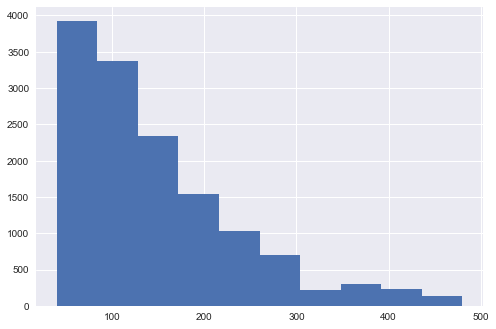

In [26]:
df_listings_smaller.price.hist()

## Null Values

In [27]:
# Checked for null values

df_listings_smaller.isnull().sum()

id                                     0
host_yrs                               0
host_response_time                  1579
host_response_rate                  1579
host_is_superhost                      0
host_listings_count                    0
host_total_listings_count              0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
city                                  14
is_location_exact                      0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             28
bedrooms                               4
beds                                  15
bed_type                               0
amenities                              0
price                                  0
security_deposit                    3367
cleaning_fee                        1849
guests_included                        0
minimum_nights  

In [28]:
# Filled null values with average

df_listings_smaller['security_deposit'].fillna(
                    value=df_listings_smaller['security_deposit'].mean(),
                    inplace=True)

df_listings_smaller['cleaning_fee'].fillna(
                    value=df_listings_smaller['cleaning_fee'].mean(),
                    inplace=True)

In [29]:
# Dropped remaining null values

df_listings_clean = df_listings_smaller.dropna()

display('Dimensions after dropping null values: ', df_listings_clean.shape)
df_listings_clean.isnull().sum()

'Dimensions after dropping null values: '

(9062, 43)

id                                  0
host_yrs                            0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_listings_count                 0
host_total_listings_count           0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood_cleansed              0
city                                0
is_location_exact                   0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
amenities                           0
price                               0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
minimum_nights                      0
number_of_reviews                   0
yrs_since_1s

In [30]:
# Removed special characters within jurisdiction
# Created a separate dataframe to keep track of juristiction info
# The dataframe will be used in later stage

df_listings_clean['jurisdiction_names'] = df_listings_clean['jurisdiction_names']  \
                                            .str.replace('[^\w\s,]', '')
df_jurisdiction = df_listings_clean.loc[:, ['id', 'jurisdiction_names']]

## Categorical Data

In [31]:
# Selected categorical variables
# Amenities feature contains a long list of amenties and will be handled separately

categorical_variables = list(df_listings_clean
                             .select_dtypes(include=['object']).columns)
categorical_variables.remove('amenities')

print ('Categorical data dimensions: ', len(categorical_variables))
df_listings_clean[categorical_variables].head()

Categorical data dimensions:  17


host_response_time host_is_superhost host_has_profile_pic  \
sf 0      within an hour                 t                    t   
   1      within an hour                 f                    t   
   2  within a few hours                 f                    t   
   3  within a few hours                 f                    t   
   5        within a day                 f                    t   

     host_identity_verified neighbourhood_cleansed           city  \
sf 0                      t       Western Addition  San Francisco   
   1                      t         Bernal Heights  San Francisco   
   2                      t         Haight Ashbury  San Francisco   
   3                      t         Haight Ashbury  San Francisco   
   5                      f       Western Addition  San Francisco   

     is_location_exact property_type        room_type  bed_type  \
sf 0                 t     Apartment  Entire home/apt  Real Bed   
   1                 t     Apartment  Entire home/apt  Real Bed   
   2                 t     Apartment     Private room  Real Bed   
   3                 t     Apartment     Private room  Real Bed   
   5                 t     Apartment  Entire home/apt  Real Bed   

     jurisdiction_names instant_bookable is_business_travel_ready  \
sf 0      SAN FRANCISCO                f                        f   
   1      SAN FRANCISCO                f                        f   
   2      SAN FRANCISCO                f                        f   
   3      SAN FRANCISCO                f                        f   
   5      SAN FRANCISCO                f                        f   

              cancellation_policy require_guest_profile_picture  \
sf 0                     moderate                             f   
   1  strict_14_with_grace_period                             f   
   2  strict_14_with_grace_period                             f   
   3  strict_14_with_grace_period                             f   
   5                     moderate                             f   

     require_guest_phone_verification       district  
sf 0                                f  San Francisco  
   1                                f  San Francisco  
   2                                f  San Francisco  
   3                                f  San Francisco  
   5                                f  San Francisco

In [32]:
# Converted categorical data to dummy variables

df_refined = pd.get_dummies(data=df_listings_clean,columns=categorical_variables)

In [33]:
print('df_refined dimensions :', df_refined.shape)
display(df_refined.columns)

df_refined dimensions : (9062, 283)


Index(['id', 'host_yrs', 'host_response_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities',
       ...
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60',
       'require_guest_profile_picture_f', 'require_guest_profile_picture_t',
       'require_guest_phone_verification_f',
       'require_guest_phone_verification_t', 'district_Oakland',
       'district_San Francisco', 'district_Santa Clara'],
      dtype='object', length=283)

## Other Feature Engineering

### List of Amenities

In [34]:
# Removed special characters within amenities

df_refined['amenities'] = df_refined['amenities'].str.replace('[^\w\s,]', '')

In [35]:
# Converted list of amenities to a dataframe

print ('Original list of amenities: ')
df_refined.amenities.head()

Original list of amenities: 


sf  0    TV,Cable TV,Internet,Wifi,Kitchen,Pets live on...
    1    Internet,Wifi,Kitchen,Heating,Familykid friend...
    2    TV,Internet,Wifi,Kitchen,Free street parking,H...
    3    TV,Internet,Wifi,Kitchen,Free street parking,H...
    5    TV,Cable TV,Internet,Wifi,Kitchen,Free parking...
Name: amenities, dtype: object

In [36]:
# Created a list captures every single amenities
# Built a dataframe based on the list
# Converted amenities to dummy variables

df_amenities = df_refined  \
               .amenities  \
               .str.get_dummies(sep = ",")  \
               .add_prefix('amenities_')

print('df_ammenities dimension: ', df_amenities.shape)
display(df_amenities.head())

df_ammenities dimension:  (9062, 182)


amenities_ toilet  amenities_24hour checkin  \
sf 0                  0                         1   
   1                  0                         0   
   2                  0                         0   
   3                  0                         0   
   5                  0                         0   

      amenities_Accessibleheight bed  amenities_Accessibleheight toilet  \
sf 0                               0                                  0   
   1                               0                                  0   
   2                               0                                  0   
   3                               0                                  0   
   5                               0                                  0   

      amenities_Air conditioning  amenities_Air purifier  \
sf 0                           0                       0   
   1                           0                       0   
   2                           0                       0   
   3                           0                       0   
   5                           0                       0   

      amenities_Amazon Echo  amenities_BBQ grill  amenities_Baby bath  \
sf 0                      0                    0                    0   
   1                      0                    0                    0   
   2                      0                    0                    0   
   3                      0                    0                    0   
   5                      0                    1                    0   

      amenities_Baby monitor  \
sf 0                       0   
   1                       0   
   2                       0   
   3                       0   
   5                       0   

                             ...                          \
sf 0                         ...                           
   1                         ...                           
   2                         ...                           
   3                         ...                           
   5                         ...                           

      amenities_Wide clearance to bed  amenities_Wide clearance to shower  \
sf 0                                0                                   0   
   1                                0                                   0   
   2                                0                                   0   
   3                                0                                   0   
   5                                0                                   0   

      amenities_Wide doorway  amenities_Wide entryway  \
sf 0                       0                        0   
   1                       0                        0   
   2                       0                        0   
   3                       0                        0   
   5                       0                        0   

      amenities_Wide hallway clearance  amenities_Wifi  \
sf 0                                 0               1   
   1                                 0               1   
   2                                 0               1   
   3                                 0               1   
   5                                 0               1   

      amenities_Window guards  amenities_Wine cooler  \
sf 0                        0                      0   
   1                        0                      0   
   2                        0                      0   
   3                        0                      0   
   5                        0                      0   

      amenities_translation missing enhosting_amenity_49  \
sf 0                                                  0    
   1                                                  0    
   2                                                  1    
   3                                                  0    
   5                                                  0    

      amenities_translation m

In [37]:
# There are over 150+ types of amenities. 
# This is to filter down to common owned amenities.

common_amenities = []
filter_percentile = 0.90

for column in df_amenities.columns:
    value = df_amenities[column].quantile(filter_percentile)
    if value > 0:
        common_amenities.append(column)

df_common_amenities = df_amenities[common_amenities]

print (common_amenities)

['amenities_24hour checkin', 'amenities_Air conditioning', 'amenities_BBQ grill', 'amenities_Bathtub', 'amenities_Bed linens', 'amenities_Breakfast', 'amenities_Cable TV', 'amenities_Carbon monoxide detector', 'amenities_Coffee maker', 'amenities_Cooking basics', 'amenities_Dishes and silverware', 'amenities_Dishwasher', 'amenities_Dryer', 'amenities_Elevator', 'amenities_Essentials', 'amenities_Extra pillows and blankets', 'amenities_Familykid friendly', 'amenities_Fire extinguisher', 'amenities_First aid kit', 'amenities_Free parking on premises', 'amenities_Free street parking', 'amenities_Garden or backyard', 'amenities_Hair dryer', 'amenities_Hangers', 'amenities_Heating', 'amenities_Host greets you', 'amenities_Hot water', 'amenities_Indoor fireplace', 'amenities_Internet', 'amenities_Iron', 'amenities_Keypad', 'amenities_Kitchen', 'amenities_Laptop friendly workspace', 'amenities_Lock on bedroom door', 'amenities_Lockbox', 'amenities_Long term stays allowed', 'amenities_Luggage 

In [38]:
display (df_common_amenities.head())

amenities_24hour checkin  amenities_Air conditioning  \
sf 0                         1                           0   
   1                         0                           0   
   2                         0                           0   
   3                         0                           0   
   5                         0                           0   

      amenities_BBQ grill  amenities_Bathtub  amenities_Bed linens  \
sf 0                    0                  0                     0   
   1                    0                  0                     0   
   2                    0                  0                     0   
   3                    0                  0                     0   
   5                    1                  0                     0   

      amenities_Breakfast  amenities_Cable TV  \
sf 0                    0                   1   
   1                    0                   0   
   2                    0                   0   
   3                    0                   0   
   5                    0                   1   

      amenities_Carbon monoxide detector  amenities_Coffee maker  \
sf 0                                   1                       0   
   1                                   0                       0   
   2                                   1                       0   
   3                                   1                       0   
   5                                   1                       1   

      amenities_Cooking basics  \
sf 0                         0   
   1                         0   
   2                         0   
   3                         0   
   5                         1   

                             ...                          amenities_Shampoo  \
sf 0                         ...                                          1   
   1                         ...                                          1   
   2                         ...                                          0   
   3                         ...                                          0   
   5                         ...                                          1   

      amenities_Single level home  amenities_Smoke detector  \
sf 0                            0                         1   
   1                            0                         1   
   2                            0                         1   
   3                            0                         1   
   5                            0                         1   

      amenities_Stepfree access  amenities_Stove  amenities_TV  \
sf 0                          0                0             1   
   1                          0                0             0   
   2                          0                0             1   
   3                          0                0             1   
   5                          0                1             1   

      amenities_Washer  amenities_Wifi  \
sf 0                 1               1   
   1                 1               1   
   2                 1               1   
   3                 1               1   
   5                 1               1   

      amenities_translation missing enhosting_amenity_49  \
sf 0                                                  0    
   1                                                  0    
   2                                                  1    
   3                                                  0    
   5                                                  0    

      amenities_translation missing enhosting_amenity_50  
sf 0                                                  0   
   1                                                  0   
   2                                                  1   
   3                                                  0   
   5                                                  0   

[5 rows x 57 columns]

In [39]:
# Concatenated common amenities dataframe with original dataframe

df_refined = pd.concat([df_refined, df_common_amenities], axis=1)

In [40]:
# Dropped original amenities feature, which is a list of amenities

df_refined.drop('amenities', axis=1, inplace=True)
df_refined.shape

(9062, 339)

### Boolean Variables

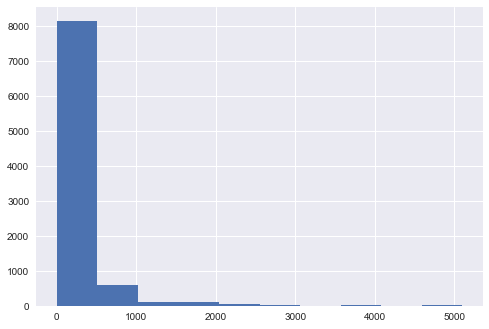

In [41]:
# Noted security_deposite amount can vary considerably among postings

df_model = df_refined.copy()
df_model.security_deposit.hist()

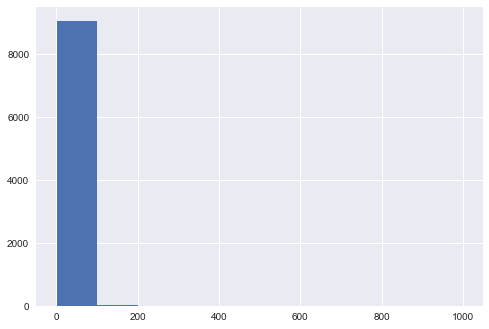

In [42]:
# Noted minimum night amount can vary considerably among postings

df_model.minimum_nights.hist()

In [43]:
# Their numerical values do not provide meaningful information for price prediction
# Converted to boolean variables instead

df_model['security_deposit'] = (df_model['security_deposit']>0) \
                                          .astype(int)

df_model['minimum_nights'] = (df_model['minimum_nights']>1)  \
                                        .astype(int)

In [44]:
df_model.shape

(9062, 339)

## Features with High Correlation

In [45]:
# Created correlation matrix
# Selected upper triangle of correlation matrix

corr_matrix = df_model.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [46]:
# Identified index of feature columns with correlation greater than 0.90

cor_thresold = 0.90

to_drop = [column for column in upper.columns if any(upper[column] >= cor_thresold)]

display (to_drop)

['host_total_listings_count',
 'host_is_superhost_t',
 'host_has_profile_pic_t',
 'host_identity_verified_t',
 'city_Cupertino',
 'city_Palo Alto',
 'city_San Jose',
 'city_Santa Clara',
 'city_Sunnyvale',
 'is_location_exact_t',
 'room_type_Private room',
 'jurisdiction_names_Cupertino, CA',
 'jurisdiction_names_OAKLAND',
 'jurisdiction_names_PALO ALTO',
 'jurisdiction_names_SAN FRANCISCO',
 'jurisdiction_names_SAN JOSE',
 'jurisdiction_names_SANTA CLARA',
 'jurisdiction_names_Santa Cruz County, CA',
 'jurisdiction_names_Sunnyvale, CA',
 'instant_bookable_t',
 'require_guest_profile_picture_t',
 'require_guest_phone_verification_t',
 'district_Oakland',
 'district_San Francisco',
 'amenities_Refrigerator',
 'amenities_Stove',
 'amenities_Washer']

In [47]:
# Dropped features with high corrleation 

df_model.drop(columns = to_drop, inplace = True)

df_model = df_model.copy()
display('Dimensions after dropping high correlated features', df_model.shape)

'Dimensions after dropping high correlated features'

(9062, 312)

In [48]:
# Stored the complete set of features

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_file_name = pkl_file.format('listings_all_features')

df_model.to_pickle(pkl_file_name)

# Modeling

## Model Preprocessing

### Train and Test Splits

In [49]:
# Performed quick regression models to get a big picture of performance, 
# and prepare for feature slections

X = df_model.drop(['id','price'], axis=1)
y = df_model['price']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
                                   X, y, test_size =0.3, random_state=42)

### Feature Normalization

In [51]:
# Normalize features 

ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Linear Regression

In [52]:
model = sm.OLS(y_train, sm.add_constant(X_train_trans))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     46.31
Date:                Sun, 17 Feb 2019   Prob (F-statistic):               0.00
Time:                        18:51:21   Log-Likelihood:                -33767.
No. Observations:                6343   AIC:                         6.812e+04
Df Residuals:                    6050   BIC:                         7.010e+04
Df Model:                         292                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.5004      0.638    226.472      0.000     143.250     145.751
x1            -1.0718      0.870     -1.231      0.218      -2.778       0.634
x2            -0.0348      1.149     -0.030      0.976      -2.286       2.217
x3             3.3668      0.955      3.525      0.000       1.494       5.239
x4            22.7893      1.461     15.603      0.000      19.926      25.652
x5             2.7437      0.801      3.425      0.001       1.173       4.314
x6            18.3480      1.189     15.433      0.000      16.017      20.679
x7            -3.2389      1.257     -2.577      0.010      -5.703      -0.775
x8            -0.5852      0.697     -0.839      0.402      -1.952       0.782
x9             9.2186      0.929      9.919      0.000       7.397      11.041
x10            7.0823      0.867      8.167      0.000       5.382       8.782
x11           -1.7917      0.772     -2.321      0.020      -3.305      -0.278
x12           -2.7294      1.171     -2.330      0.020      -5.025      -0.433
x13           -2.8604      1.148     -2.491      0.013      -5.111      -0.610
x14            3.7700      1.313      2.872      0.004       1.197       6.343
x15            1.1524      1.059      1.088      0.277      -0.924       3.229
x16            5.0383      0.933      5.401      0.000       3.210       6.867
x17           -2.6001      0.950     -2.736      0.006      -4.463      -0.737
x18           -0.2243      1.027     -0.218      0.827      -2.237       1.789
x19            4.0483      0.902      4.489      0.000       2.280       5.816
x20           -4.8526      1.052     -4.614      0.000      -6.914      -2.791
x21          -10.4004      1.014    -10.257      0.000     -12.388      -8.413
x22           -5.3751      1.117     -4.813      0.000      -7.565      -3.186
x23           -0.1775      1.039     -0.171      0.864      -2.214       1.860
x24           -0.7745      0.589     -1.314      0.189      -1.930       0.381
x25           -1.3443      0.483     -2.785      0.005      -2.290      -0.398
x26            1.6990      0.447      3.803      0.000       0.823       2.575
x27           -4.3637      0.764     -5.712      0.000      -5.861      -2.866
x28            0.4196      0.686      0.611      0.541      -0.926       1.765
x29           -2.5603      0.763     -3.354      0.001      -4.057      -1.064
x30            0.8793      0.654      1.344      0.179      -0.404       2.162
x31           -1.6237      0.839     -1.935      0.053      -3.268       0.021
x32           -1.0959      0.696     -1.573      0.116      -2.461       0.269
x33           -0.9677      0.674     -1.436      0.151      -2.288       0.353
x34           -0.5047      0.658     -0.767      0.443      -1.795       0.785
x35           -0.5085      0.650     -0.783      0.434      -1.782       0.765
x3

## Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
rf.fit(X_train_trans, y_train)
y_train_pred = rf.predict(X_train_trans)
y_test_pred = rf.predict(X_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

## Feature Selection

In [ ]:
# Sorted feature by importance

feature_labels = X.columns
feature_tuples = zip (feature_labels, rf.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]

feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)

display (feature_lists[0:5])

In [ ]:
# Kept features that are above 0.001 thresold

features_selected = [feature for feature, importance in feature_lists
                    if importance >= 0.001]

nums_features_selected = len(features_selected)

print ('Number of features kept: ', nums_features_selected)

## Model with Selected Features

In [ ]:
# Performed another model(Random Forest) based on selected features

X_updated = df_model[features_selected]
y_updated = df_model['price']

In [ ]:
X_updated_train, X_updated_test, y_updated_train, y_updated_test = train_test_split(
    X_updated, y_updated, test_size =0.3, random_state=42)

In [ ]:
ssX2 = StandardScaler()
X_updated_train_trans = ssX2.fit_transform(X_updated_train)
X_updated_test_trans = ssX2.transform (X_updated_test)

In [ ]:
rf_updated = RandomForestRegressor(n_estimators=500, 
                                   criterion='mse', 
                                   random_state=3, 
                                   n_jobs=-1)
rf_updated.fit(X_updated_train_trans, y_updated_train)
y_updated_train_pred = rf_updated.predict(X_updated_train_trans)
y_updated_test_pred = rf_updated.predict(X_updated_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_updated_train, y_updated_train_pred),
        mean_squared_error(y_updated_test, y_updated_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_updated_train, y_updated_train_pred),
        r2_score(y_updated_test, y_updated_test_pred)))

# Data Storage

In [ ]:
# Kept 'id', and all selected features

columns = ['id'] + features_selected
df_important_features = df_model[columns]
df_important_features.head()

In [ ]:
# Added District and jurisdiction informaiton for future use

df_listings_selected_features = pd.merge(left=df_important_features, 
                                    right=df_district, 
                                    how ='left', 
                                    left_on='id',
                                    right_on='id')


df_listings_selected_features = pd.merge(left=df_listings_selected_features, 
                                    right=df_jurisdiction, 
                                    how ='left', 
                                    left_on='id',
                                    right_on='id')


# Renamed columns used for furture reference

df_listings_selected_features.rename(columns={'district':'ref_district',
                                             'jurisdiction_names': 'ref_jurisdiction'},
                                     inplace=True)

print('df_listings_selected_features dimensions: ', 
       df_listings_selected_features.shape)
display(df_listings_selected_features.head())

In [ ]:
# Checked for null values before data storage

# df_listings_selected_features.isnull().sum()

In [ ]:
# Stored data post feature selection

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_path = pkl_file.format('df_listings_selected_features')

df_listings_selected_features.to_pickle(pkl_path)